# Demonstrate examples for collaboration with novo nordisk

In [1]:
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils
import torch.nn as nn

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 4
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 0
binary_intervention=True

In [2]:
df_tr = generate_data_causl(n=2000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

## specify causal margin

In [7]:
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=4000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.6580, loss1 2.8143, loss2 0.3125
Epoch 1000: loss 1.9945, loss1 3.9390, loss2 3.8890
Epoch 2000: loss 1.9827, loss1 3.9429, loss2 3.9203
Epoch 3000: loss 1.9879, loss1 3.9552, loss2 3.9347
Epoch 4000: loss 1.9604, loss1 3.9322, loss2 3.9437
Epoch 1: loss 3.1329,	loss_y 2.3610, 2.3741, 0.0262,	loss_eta 0.7719, 0.8041, 0.0643
Epoch 1000: loss 1.1224,	loss_y 0.5567, 1.1151, 1.1169,	loss_eta 0.5657, 1.1168, 1.1022
Epoch 2000: loss 1.0960,	loss_y 0.5371, 1.1146, 1.1550,	loss_eta 0.5589, 1.1077, 1.0975


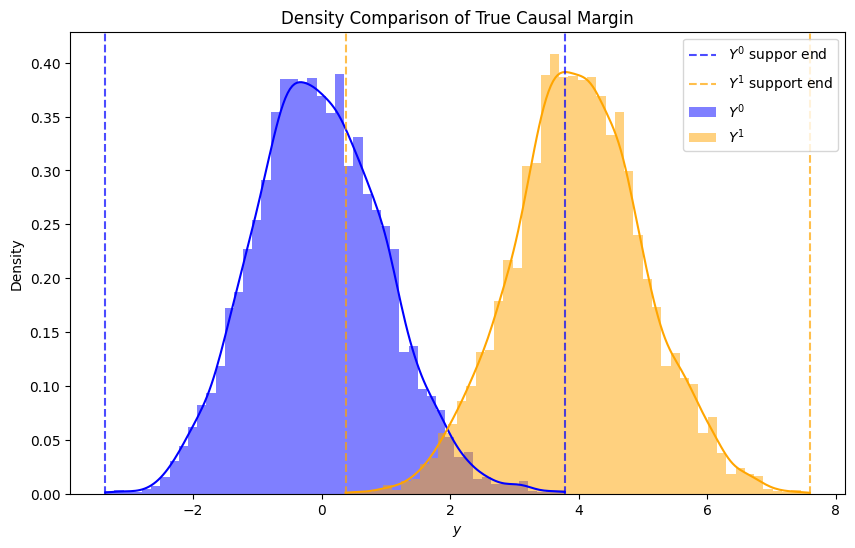

In [8]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=6000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=6000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [9]:
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=50000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(4.0191)
Proportion of sampled treated:  tensor(0.5268)
Proportion of true treated:  tensor(0.5017)


In [10]:
df_tr = generate_data_causl(n=3000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

In [23]:
class SpecifiedCausalMargin(nn.Module):
    def __init__(self, ate,x_dim):
        super().__init__()
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim

    def forward(self, x_eta):
        # If 'eta' is truly separate, might need to handle that carefully
        x = x_eta[:, :self.x_dim]
        eta = x_eta[:, self.x_dim:]
        return self.ate * x + eta

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)

margin_module = SpecifiedCausalMargin(ate=0, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)

model.train_xz(x_tr, z_tr, num_iters=4000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=15000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.6760, loss1 2.8148, loss2 0.2777
Epoch 1000: loss 1.9850, loss1 3.9418, loss2 3.9135
Epoch 2000: loss 1.9781, loss1 3.9323, loss2 3.9083
Epoch 3000: loss 1.9761, loss1 3.9618, loss2 3.9714
Epoch 4000: loss 1.9574, loss1 3.9505, loss2 3.9862
Epoch 1: loss 3.1734,	loss_y 2.4121, 2.4217, 0.0192,	loss_eta 0.7613, 0.7995, 0.0765
Epoch 1000: loss 1.6247,	loss_y 0.7272, 1.4309, 1.4074,	loss_eta 0.8975, 2.1264, 2.4578
Epoch 2000: loss 1.5597,	loss_y 0.7228, 1.5300, 1.6144,	loss_eta 0.8370, 2.0716, 2.4693
Epoch 3000: loss 1.5134,	loss_y 0.7131, 1.4728, 1.5194,	loss_eta 0.8003, 2.0446, 2.4886
Epoch 4000: loss 1.5787,	loss_y 0.6944, 1.4470, 1.5051,	loss_eta 0.8843, 2.0788, 2.3890
Epoch 5000: loss 1.5559,	loss_y 0.7144, 1.4709, 1.5130,	loss_eta 0.8415, 2.0633, 2.4435
Epoch 6000: loss 1.5507,	loss_y 0.6957, 1.4836, 1.5758,	loss_eta 0.8550, 2.0665, 2.4230
Epoch 7000: loss 1.5148,	loss_y 0.6858, 1.4103, 1.4488,	loss_eta 0.8289, 2.0435, 2.4292
Epoch 8000: loss 1.5249,	loss_y 0.6632, 1.

In [21]:
model.train_y(x_tr, z_tr, y_tr, num_iters=8000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 1.4980,	loss_y 0.6586, 1.4233, 1.5294,	loss_eta 0.8394, 2.0470, 2.4153
Epoch 1000: loss 1.5159,	loss_y 0.6738, 1.4156, 1.4835,	loss_eta 0.8421, 2.0819, 2.4795
Epoch 2000: loss 1.4884,	loss_y 0.6302, 1.3762, 1.4919,	loss_eta 0.8581, 2.0721, 2.4279
Epoch 3000: loss 1.5009,	loss_y 0.6361, 1.3702, 1.4683,	loss_eta 0.8648, 2.0616, 2.3935
Epoch 4000: loss 1.4577,	loss_y 0.6082, 1.3411, 1.4658,	loss_eta 0.8495, 2.0857, 2.4724
Epoch 5000: loss 1.4746,	loss_y 0.6041, 1.2976, 1.3871,	loss_eta 0.8705, 2.0686, 2.3962
Epoch 6000: loss 1.3986,	loss_y 0.5870, 1.3171, 1.4603,	loss_eta 0.8116, 2.0515, 2.4798
Epoch 7000: loss 1.3841,	loss_y 0.5849, 1.2797, 1.3896,	loss_eta 0.7992, 2.0515, 2.5046
Epoch 8000: loss 1.4367,	loss_y 0.5778, 1.2659, 1.3762,	loss_eta 0.8589, 2.0924, 2.4669


In [24]:
# Sample joint
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=50000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(3.0267)
Proportion of sampled treated:  tensor(0.5077)
Proportion of true treated:  tensor(0.5047)


In [28]:
class SpecifiedCausalMargin(nn.Module):
    def __init__(self, ate,x_dim):
        super().__init__()
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim

    def forward(self, x_eta):
        # If 'eta' is truly separate, might need to handle that carefully
        x = x_eta[:, :self.x_dim]
        eta = x_eta[:, self.x_dim:]
        return self.ate * x + eta

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)

margin_module = SpecifiedCausalMargin(ate=2, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)

model.train_xz(x_tr, z_tr, num_iters=4000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=4000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.6851, loss1 2.8056, loss2 0.2411
Epoch 1000: loss 1.9935, loss1 3.9365, loss2 3.8860
Epoch 2000: loss 1.9707, loss1 3.9427, loss2 3.9440
Epoch 3000: loss 1.9736, loss1 3.9241, loss2 3.9009
Epoch 4000: loss 1.9819, loss1 3.9445, loss2 3.9251
Epoch 1: loss 2.1476,	loss_y 1.3970, 1.4044, 0.0148,	loss_eta 0.7506, 0.7980, 0.0946
Epoch 1000: loss 1.2683,	loss_y 0.6157, 1.1714, 1.1114,	loss_eta 0.6526, 1.4002, 1.4951
Epoch 2000: loss 1.2651,	loss_y 0.6146, 1.1741, 1.1191,	loss_eta 0.6505, 1.4258, 1.5505
Epoch 3000: loss 1.2628,	loss_y 0.5935, 1.1572, 1.1275,	loss_eta 0.6693, 1.4353, 1.5320
Epoch 4000: loss 1.2150,	loss_y 0.5899, 1.1466, 1.1133,	loss_eta 0.6251, 1.4127, 1.5752


In [29]:
# Sample joint
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=50000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(3.7565)
Proportion of sampled treated:  tensor(0.5412)
Proportion of true treated:  tensor(0.5047)
